In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random
from sklearn import tree
from sklearn.cluster import KMeans

plt.style.use('seaborn')

### Loading data

In [2]:
path = r"/home/dazai/Documents/Process mining/Data/BPI 2012/"
df_train = pd.read_csv(f'{path}BPI_Challenge_2012-training.csv')
df_test = pd.read_csv(f'{path}BPI_Challenge_2012-test.csv')


df_data = pd.concat([df_train, df_test])
df_data['event time:timestamp'] = pd.to_datetime(df_data['event time:timestamp'], dayfirst=True).dt.date
# df_data['event time:timestamp'] = df_data['event time:timestamp'].to_timestamp()
df_data.sort_values(by=['event time:timestamp'])
df_data.reset_index(inplace=True, drop=True)
# df_data.drop(['case description', 'event org:resource'], axis=1, inplace=True)

# remove whitespace at beginning and end of column name
df_data.columns = df_data.columns.str.strip()



### Label Encoding 
NOTE: To make the sliding window model work, We will use label encoding for 'event concept:name' to preserve one outcome variable  <br><br>

In [3]:
# Get unique activities and encode them
Y = df_data['event concept:name'].unique()
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Y)

# Randomly selecting a few to test
randomYs = random.choices(Y, k=5)
print(randomYs)
label_encoder.transform(randomYs)

['A_CANCELLED', 'A_ACCEPTED', 'A_REGISTERED', 'O_CANCELLED', 'A_PARTLYSUBMITTED']


array([ 3,  0,  8, 11,  6])

In [4]:
# Get dummy variables and encode lifecycle
df_dummies_lifecycle = pd.get_dummies(df_data['event lifecycle:transition'], prefix='Lifecycle', drop_first=True)
df_encoded = df_data.loc[:, df_data.columns != 'event lifecycle:transition'].copy().join(df_dummies_lifecycle)

# Encode event concept name
df_encoded['event concept:name'] = label_encoder.transform(df_data['event concept:name'])
df_encoded

,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event time:timestamp,Lifecycle_SCHEDULE,Lifecycle_START
0,0,173688,2011-10-01T00:38:44.546+02:00,20000,9,2011-10-01,0,0
1,1,173688,2011-10-01T00:38:44.546+02:00,20000,6,2011-10-01,0,0
2,2,173688,2011-10-01T00:38:44.546+02:00,20000,7,2011-10-01,0,0
3,3,173688,2011-10-01T00:38:44.546+02:00,20000,19,2011-10-01,1,0
4,4294967296,173691,2011-10-01T08:08:58.256+02:00,5000,9,2011-10-01,0,0
...,...,...,...,...,...,...,...,...
262195,54666343743523,213276,2012-02-27T14:12:41.868+01:00,15000,20,2012-03-14,0,1
262196,54666343743524,213276,2012-02-27T14:12:41.868+01:00,15000,20,2012-03-14,0,0
262197,49495203119136,209595,2012-02-15T10:10:36.503+01:00,13000,21,2012-03-14,0,1
262198,52342766436386,211624,2012-02-21T23:38:40.044+01:00,35000,20,2012-03-14,0,1


### Implementation of One-Hot encoding

In [6]:
# dummy variables encoded
df_dummies_name = pd.get_dummies(df_data['event concept:name'], prefix='Event Name', drop_first=True)

# adding encoded values 
cols = df_data.columns[:-3].tolist()
df_ohencoded = df_data[cols].copy().join(df_dummies_name).join(df_dummies_lifecycle)

In [7]:
df_ohencoded

,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,Event Name_A_ACTIVATED,Event Name_A_APPROVED,Event Name_A_CANCELLED,Event Name_A_DECLINED,Event Name_A_FINALIZED,Event Name_A_PARTLYSUBMITTED,...,Event Name_O_SENT_BACK,Event Name_W_Afhandelen leads,Event Name_W_Beoordelen fraude,Event Name_W_Completeren aanvraag,Event Name_W_Nabellen incomplete dossiers,Event Name_W_Nabellen offertes,Event Name_W_Valideren aanvraag,Event Name_W_Wijzigen contractgegevens,Lifecycle_SCHEDULE,Lifecycle_START
0,0,173688,2011-10-01T00:38:44.546+02:00,20000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,173688,2011-10-01T00:38:44.546+02:00,20000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2,173688,2011-10-01T00:38:44.546+02:00,20000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,173688,2011-10-01T00:38:44.546+02:00,20000,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,4294967296,173691,2011-10-01T08:08:58.256+02:00,5000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262195,54666343743523,213276,2012-02-27T14:12:41.868+01:00,15000,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
262196,54666343743524,213276,2012-02-27T14:12:41.868+01:00,15000,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
262197,49495203119136,209595,2012-02-15T10:10:36.503+01:00,13000,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
262198,52342766436386,211624,2012-02-21T23:38:40.044+01:00,35000,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


### Implementation of sliding window transformation
Note: For every row in the dataset the activity name of the CURRENT row is the Y value, the x values consist of: ALL columns of current row without current Y + ALL columns from LAST row including last Y. So the first and last values in the dataset will be discarded as there is either no input or output

In [8]:
# we will convert the ID's to string to prevent rounding can convert back if needed
df_encoded['eventID'] = df_encoded['eventID'].astype('str')


NOTE: To encode the cyclical nature of cyclical features like days and months, we split the variable into a sine and cosine part where together they will represent a circle. This will allow the cyclical nature of the encoded variable


In [6]:
def single_sliding_window(df):
    """Extracts sliding window of size 1
       with the event of next row as Y"""
    # The event name of next row is the Y
    df['Y'] = df.shift(-1)['event concept:name']

    # Pick columns that you want to include
    cols = df.columns.tolist()
    wanted_index = [3,4,6,7,8]
    cols = [i[1] for i in enumerate(cols) if i[0] in wanted_index]

    # Current row + last row together as predictors
    current = df[cols[:-1]].iloc[1:-1 ,:]
    last = df[cols[:-1]].shift(1).iloc[1:-1 ,:]

    Y = df['Y'].to_numpy()[1:-1]
    X = [x + x1 for x, x1 in zip(current.to_numpy().tolist(), last.to_numpy().tolist())]
    return X, Y



X, Y = sliding_window(df_encoded);

Note: Y value in this case is the actual next event. With input x1,x2,x3... where X consists of all columns from last row and all columns from current row excluding Y. The Y value from last row acts as a predictor x for current row to predict Y next event

### NOTE: We can see that the majority of cases are in between 3 and 31

count    13087.000000
mean        20.035149
std         19.944321
min          3.000000
25%          3.000000
50%         11.000000
75%         31.000000
max        175.000000
Name: case concept:name, dtype: float64


<AxesSubplot:xlabel='case concept:name'>

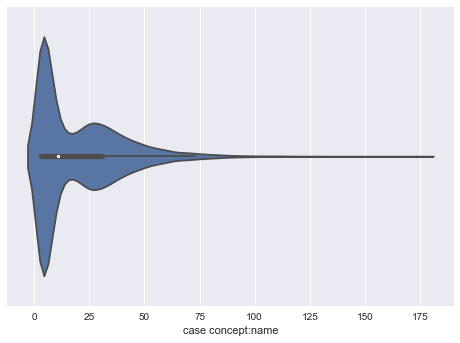

In [10]:
print(df_encoded['case concept:name'].value_counts().describe())
sns.violinplot(x=df_encoded['case concept:name'].value_counts())

In [57]:
def sliding_window(df, size, window):
    """Takes cleaned dataframe as input along
    with the number of elements in sliding window
    and the number of windows (size). Returns
    X and Y in array form"""
    start = 0
    X = []
    Y = []

    traces = df['case concept:name'].unique()

    for i in traces:
        # Get each trace larger than windows * size + 1
        trace = df[df['case concept:name']==i]
        if len(trace) > size * window +1:
            # Loop through trace with window of 3 step size 1
            for j in range(1,window+1):
                curr_window = trace.iloc[start:start+window+1]
                X.append(np.concatenate(curr_window.iloc[:3].to_numpy()))
                Y.append(curr_window.iloc[3]['event concept:name'])
                start += 1
            start = 0
        else:
            # what to do if traces are shorter than window?
            continue
    return X, Y

In [60]:
df = df_encoded[df_encoded['case concept:name']==173688][['case concept:name', 'case AMOUNT_REQ', 'event concept:name', 'Lifecycle_SCHEDULE', 'Lifecycle_START']]
sliding_window(df, 2, 3)

([array([173688,  20000,      9,      0,      0, 173688,  20000,      6,
              0,      0, 173688,  20000,      7,      0,      0]),
  array([173688,  20000,      6,      0,      0, 173688,  20000,      7,
              0,      0, 173688,  20000,     19,      1,      0]),
  array([173688,  20000,      7,      0,      0, 173688,  20000,     19,
              1,      0, 173688,  20000,     19,      0,      1])],
 [19, 19, 0])

NOTE: question is now which variables do we want to take into account

# TEST

In [64]:
df = df_encoded[['case concept:name', 'case AMOUNT_REQ', 'event concept:name', 'Lifecycle_SCHEDULE', 'Lifecycle_START']]
X, Y = sliding_window(df, 3, 3)

In [65]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
# Training and fitting dctree on X and predicting on Y 
d_tree = tree.DecisionTreeClassifier()
d_tree.fit(x_train, y_train)

y_pred = d_tree.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8605431797375649

## Implementing prototype selection

Text(0, 0.5, 'WCSS')

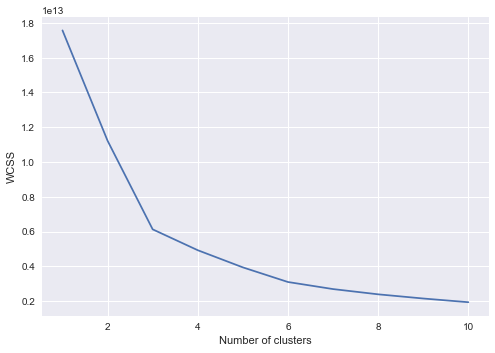

In [66]:
# look for optimal amount of clusters (elbow)
wcss = [] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X) 
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 

We take n closest elements to the centroids from the dataset and use it as training set


In [75]:
from sklearn.metrics import pairwise_distances
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)

X = np.array(X)
x_train = np.array(x_train)
y_train = np.array(y_train)
n = 1000
distances = pairwise_distances(kmeans.cluster_centers_, x_train, metric='euclidean')
ind = [np.argpartition(i, n)[:n] for i in distances]
closest_x = [x_train[indexes] for indexes in ind]
closest_y = [y_train[indexes] for indexes in ind]


In [76]:
closest_x = [item for sublist in closest_x for item in sublist]
closest_y = [item for sublist in closest_y for item in sublist]

In [77]:
d_tree = tree.DecisionTreeClassifier()
d_tree.fit(closest_x, closest_y)

y_pred = d_tree.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8497101007018615